So here's something pepega about this project.

I don't know how to start it.

In [5]:
# Import packages

import numpy as np    
import matplotlib.pyplot as plt       
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [46]:
# Load and resize data

classes = ("Tench", "English Springer", "Cassette Player", "Chain Saw", "Church", "French Horn", "Garbage Truck", "Gas Pump", "Golf Ball", "Parachute")

def load_data():
  train = "imagenette2/train"
  val = "imagenette2/val"

  train_dataset = ImageFolder(
    train,
    transforms.Compose([
        transforms.RandomResizedCrop(300),  # image size int or tuple
        transforms.ToTensor(),  # convert to tensor at the end
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

  val_dataset = ImageFolder(
    val,
    transforms.Compose([
        transforms.RandomResizedCrop(300),  # image size int or tuple
        transforms.ToTensor(),  # convert to tensor at the end
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

  train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True)
  
  return train_dataloader, val_dataloader

In [43]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
        
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(12)
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(12)
    self.pool = nn.MaxPool2d(2,2)
    self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(24)
    self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(24)
    self.fc1 = nn.Linear(24*144*144, 10)
  
  def forward(self, input):
    output = F.relu(self.bn1(self.conv1(input)))      
    output = F.relu(self.bn2(self.conv2(output)))     
    output = self.pool(output)                        
    output = F.relu(self.bn4(self.conv4(output)))     
    output = F.relu(self.bn5(self.conv5(output)))     
    output = output.view(-1, 24*144*144)
    output = self.fc1(output)

    return output

# Instantiate a neural network model 
model = Network()

In [8]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [24]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./classifier_full.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            print(i)
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 50 images
            running_loss += loss.item()     # extract the loss value
            if i % 50 == 49:    
                # print every 50 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [45]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch(batch_size):
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

def testClassess(batch_size, number_of_labels):
    class_correct = list(0. for i in range(number_of_labels))
    class_total = list(0. for i in range(number_of_labels))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

The model will be running on cpu device
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[1,    50] loss: 2.410
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
For epoch 1 the test accuracy over the whole test set is 12 %
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[2,    50] loss: 2.393
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
For epoch 2 the test accuracy over the whole test set is 9 %
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[3,    50] loss: 2.364
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


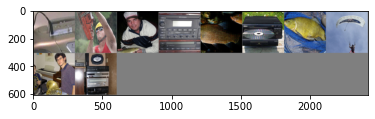

Real labels:  Chain Saw English Springer Golf Ball Chain Saw Golf Ball Chain Saw Golf Ball French Horn Church Chain Saw
tensor([5, 8, 5, 8, 4, 8, 4, 5, 4, 4]) tensor([3, 1, 8, 3, 8, 3, 8, 5, 4, 3])
Predicted:  French Horn Golf Ball French Horn Golf Ball Church Golf Ball Church French Horn Church Church
Accuracy of Tench : 23 %
Accuracy of English Springer :  0 %
Accuracy of Cassette Player :  0 %
Accuracy of Chain Saw :  0 %
Accuracy of Church : 23 %
Accuracy of French Horn : 53 %
Accuracy of Garbage Truck :  3 %
Accuracy of Gas Pump :  6 %
Accuracy of Golf Ball :  3 %
Accuracy of Parachute :  3 %


In [44]:
# Let's build our model
train_loader, test_loader = load_data()

train(5)
print('Finished Training')

# Let's load the model we just created and test the accuracy per label
model = Network()
path = "classifier.pth"
model.load_state_dict(torch.load(path))

# Test with batch of images
testBatch(10)

# Test which classes performed well
testClassess(10, 10)

In [ ]:
# Let's build our model
train_loader, test_loader = load_data()

train(5)
print('Finished Training')

# Let's load the model we just created and test the accuracy per label
model = Network()
path = "classifier_full.pth"
model.load_state_dict(torch.load(path))

# Test with batch of images
testBatch(10)

# Test which classes performed well
testClassess(10, 10)